In [1]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from tqdm import tqdm
# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from enum import Enum
import time
import requests

# Basics of Python data handling and visualization
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm import tqdm_notebook as tqdm
from pyproj import Proj, transform
# Machine learning
import lightgbm as lgb
from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam


import rasterio
from rasterio.plot import show
from shapely.geometry import box
import fiona
import rasterio.mask
from rasterio.features import shapes
from pathlib import Path


gisdb = os.path.join(os.path.expanduser("~"), "Documents")
location = "nc_spm_08"
mapset = "PERMANENT"
gisbase='/Applications/GRASS-7.6.app/Contents/Resources'
os.environ['GISBASE'] = gisbase
grass_pydir = os.path.join(gisbase, "etc", "python")
sys.path.append(grass_pydir)
os.environ['LD_LIBRARY_PATH']="/Applications/GRASS-7.6.app/Contents/Resources/lib"
import grass.script as gscript
import grass.script.setup as gsetup

/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install 

In [2]:
s_date='2017-01-01'
e_date='2019-06-01'
cname='Pittsburgh'

# lat_left_top,lon_left_top=(5.967731, 80.533445) #Matara
# lat_right_bot,lon_right_bot=(5.934423, 80.571918)


# lat_left_top,lon_left_top=(40.045358, -75.060472) #philly
# lat_right_bot,lon_right_bot=(40.024618, -74.995083)

# lat_left_top,lon_left_top=(31.392174, 121.449847) #Shanghai
# lat_right_bot,lon_right_bot=(31.299187, 121.594961)

# lat_left_top,lon_left_top=(51.515825, -0.037599) #London
# lat_right_bot,lon_right_bot=(51.489779, 0.035069)

# lat_left_top,lon_left_top=(41.434410, 2.181226) #BCN
# lat_right_bot,lon_right_bot=(41.406936, 2.243418)

# lat_left_top,lon_left_top=(39.295688, -76.631894) #Baltimore
# lat_right_bot,lon_right_bot=(39.271539, -76.590152)

# lat_left_top,lon_left_top=(40.355395, -74.671046) #Princeton
# lat_right_bot,lon_right_bot=(40.325833, -74.612189)

# lat_left_top,lon_left_top=(6.981137, 79.861419) #Colombo
# lat_right_bot,lon_right_bot=(6.940209, 79.909089)

# lat_left_top,lon_left_top=(9.696584, 80.002679) #Jaffna
# lat_right_bot,lon_right_bot=(9.642673, 80.042429)

lat_left_top,lon_left_top=(40.480010, -80.039996) #Pittsburgh
lat_right_bot,lon_right_bot=(40.426980, -79.973610)

size=10
scale=abs(lat_left_top-lat_right_bot)/abs(lon_left_top-lon_right_bot)

GUFF_data=False
GUFF_data_dir='Data/urban_foot_print/SriLanka04.tif'

#Building_data='OSM' 
Building_data='MICROSOFT' 
building_dir='Data/Buildings_US_Microsoft/Pennsylvania.geojson'

In [3]:

def clip_points(shp, clip_obj):
    '''
    Docs Here
    '''

    poly = clip_obj.geometry.unary_union
    return(shp[shp.geometry.intersects(poly)])

# Create function to clip line and polygon data using geopandas


def clip_line_poly(shp, clip_obj):
    '''
    docs
    '''

    # Create a single polygon object for clipping
    poly = clip_obj.geometry.unary_union
    spatial_index = shp.sindex

    # Create a box for the initial intersection
    bbox = poly.bounds
    # Get a list of id's for each road line that overlaps the bounding box and subset the data to just those lines
    sidx = list(spatial_index.intersection(bbox))
    shp_sub = shp.iloc[sidx]

    # Clip the data - with these data
    clipped = shp_sub.copy()
    clipped['geometry'] = shp_sub.intersection(poly)

    # Return the clipped layer with no null geometry values
    return(clipped[clipped.geometry.notnull()])


# Final clip function that handles points, lines and polygons


def clip_shp(shp, clip_obj):
    '''
    '''
    if shp["geometry"].iloc[0].type == "Point":
        return(clip_points(shp, clip_obj))
    else:
        return(clip_line_poly(shp, clip_obj))

In [4]:
def grass_union(v1_dir,v2_dir,out_dir):
    gsetup.init(gisbase, gisdb, location, mapset)

    gscript.run_command("g.proj",flags="c" ,proj4="+proj=longlat +datum=WGS84 +no_defs")

    gscript.run_command("v.in.ogr", 
    min_area=0.0001 ,
    snap=-1.0, 
    input=v1_dir, 
    output="vector3", 
    overwrite=True, 
    flags="o")

    gscript.run_command("v.in.ogr", 
    min_area=0.0001 ,
    snap=-1.0, 
    input=v2_dir, 
    output="vector4", 
    overwrite=True, 
    flags="o")

    raster=rasterio.open(path_out+'/predicted_tiff'+'/merged_prediction.tiff')
    df=raster.bounds

    gscript.run_command("g.region",
    n=df.top,
    s=df.bottom,
    e=df.right,
    w=df.left)

    gscript.run_command("v.overlay", 
    overwrite=True,
    ainput="vector3",
    atype="area", 
    binput="vector4", 
    btype="area", 
    operator='or', 
    snap=0, 
    output="output_b")

    out_file='converted_temp.geojson'
    gscript.run_command("v.out.ogr",
    type="auto",
    input="output_b",
    output=out_file,
    format="GeoJSON",
    overwrite=True)


    temp=gpd.read_file(out_file)
    os.remove(out_file)
    temp.crs={'init' :'epsg:4326'}
    temp.to_file(out_dir)

In [5]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool),
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

class CountValid(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))

        return eopatch


class NormalizedDifferenceIndex(EOTask):
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])

    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]

        ndi = (band_a - band_b) / (band_a  + band_b)

        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])

        return eopatch


class EuclideanNorm(EOTask):
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name

    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))

        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch

In [6]:

# TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12)
# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover
# detection is performed in the next step
custom_script = 'return [B02, B03, B04, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C',
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.1, # maximum allowed cloud cover of original ESA tiles
)

# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution
# and the resulting cloud probability map and mask
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m',
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(),
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
path_out =cname
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [7]:
class LULC(Enum):
    OTHER              = (0,  'Paved+Built+other',              'red')
    VEG                = (1,  'Veg',                            'green')
    Water              = (2,  'Water',                          'blue')
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

# example usecase
# LULC.BARELAND.id   # return 9

# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 3, 1), lulc_cmap.N)

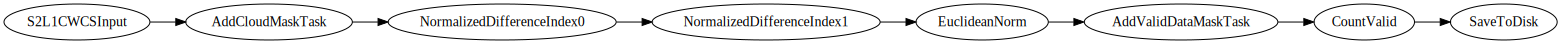

In [8]:
# Define the workflow
workflow = LinearWorkflow(
    add_data,
    add_clm,
    ndvi,
    ndwi,
    norm,
    add_sh_valmask,
    count_val_sh,
    save
)

# Let's visualize it
workflow.dependency_graph()

In [9]:
%%time
# Execute the workflow

time_interval = [s_date, e_date] # time interval for the SH request

# define additional parameters of the workflow
execution_args = []

execution_args.append({
    add_data:{'bbox': BBox(((lon_left_top,lat_left_top),(lon_right_bot,lat_right_bot)), crs=CRS.WGS84),
            'time_interval': time_interval},
    save: {'eopatch_folder': 'eopatch_{}'.format(0)}
    })

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=False)

executor.make_report()


CPU times: user 14.6 s, sys: 3.25 s, total: 17.9 s
Wall time: 42.8 s


In [21]:
# Draw the RGB image
size=20
eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, 0), lazy_loading=True)
image_dir=path_out+'/images'
if not os.path.isdir(image_dir):
    os.makedirs(image_dir)

print('saving the images into '+image_dir)
pbar = tqdm(total=21)
for i in range(eopatch.data['BANDS'].shape[0]):
    
    fig = plt.figure(figsize=(size*1, size*scale))
    ax = plt.subplot(1, 1, 1)
    plt.imshow(np.clip(eopatch.data['BANDS'][i][..., [2,1,0]] * 3.5, 0, 1))
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    plt.savefig(image_dir+'/'+str(i)+'.png')
    plt.close()
    
pic_n=10


saving the images into Pittsburgh/images


In [39]:
model_path = './model.pkl'
model = joblib.load(model_path)

In [40]:
class ConcatenateData(EOTask):
    """ Task to concatenate data arrays along the last dimension
    """
    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, np.concatenate(arrays, axis=-1))

        return eopatch


class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid, if the
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold
    

In [41]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk(path_out)

# TASK FOR CONCATENATION
concatenate = ConcatenateData('FEATURES', ['BANDS', 'NDVI', 'NDWI', 'NORM'])
#concatenate = ConcatenateData('FEATURES', ['BANDS'])
# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling

# TASK FOR EROSION
# erode each class of the reference map
# erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'LULC','LULC_ERODED'), disk_radius=1)

# TASK FOR SPATIAL SAMPLING
# Uniformly sample about pixels from patches
# n_samples = int(4e4) if use_smaller_patches else int(1e5) # no. of pixels to sample
# ref_labels = list(range(11)) # reference labels to take into account when sampling
# spatial_sampling = PointSamplingTask(
#     n_samples=n_samples,
#     ref_mask_feature='Build_ERODED',
#     ref_labels=ref_labels,
#     sample_features=[  # tag fields to sample
#         (FeatureType.DATA, 'FEATURES'),
#         (FeatureType.MASK_TIMELESS, 'Build_ERODED')
#     ])


save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)



In [42]:
workflow = LinearWorkflow(
    load,
    concatenate,
#    filter_task,
#    linear_interp,
#     erosion,
#     spatial_sampling,
    save
)

In [43]:
%%time

execution_args = []
for idx in range(0,1):
    execution_args.append({
        load: {'eopatch_folder': 'eopatch_{}'.format(idx)},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    })

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=True)

executor.make_report()


CPU times: user 56.1 ms, sys: 49.2 ms, total: 105 ms
Wall time: 2.66 s


In [44]:
class PredictPatch(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature,
    and the output names of labels and scores (optional)
    """
    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name

    def execute(self, eopatch):
        ftrs = eopatch[self.features_feature[0]][self.features_feature[1]][pic_n,:,:,:]
        #ftrs = np.mean(eopatch[self.features_feature[0]][self.features_feature[1]][:,:,:,:],axis=0)
        #ftrs = eopatch[self.features_feature[0]][self.features_feature[1]][pic_n,:,:,7]

        #t, w, h, f = ftrs.shape
        w, h, f = ftrs.shape
        #w, h = ftrs.shape
        
        #ftrs = np.moveaxis(ftrs, 0, 2).reshape(w * h, 1 * f)
        ftrs = ftrs.reshape(w * h, 1 * f)
        #ftrs = ftrs.reshape(w * h, 1 * 1)

        plabels = self.model.predict(ftrs)
        plabels = plabels.reshape(w, h)
        plabels = plabels[..., np.newaxis]
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.predicted_labels_name, plabels)

        if self.predicted_scores_name:
            pscores = self.model.predict_proba(ftrs)
            _, d = pscores.shape
            pscores = pscores.reshape(w, h, d)
            eopatch.add_feature(FeatureType.DATA_TIMELESS, self.predicted_scores_name, pscores)

        return eopatch

In [45]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk(path_out)

# TASK FOR PREDICTION
predict = PredictPatch(model, (FeatureType.DATA, 'FEATURES'), 'LBL', 'SCR')

# TASK FOR SAVING
#path_out_sampled = './eopatches_sampled_small_'+cname+'_2/' if use_smaller_patches else './eopatches_sampled_large/'
#if not os.path.isdir(path_out_sampled):
#    os.makedirs(path_out_sampled)
save = SaveToDisk(str(path_out), overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# TASK TO EXPORT TIFF
export_tiff = ExportToTiff((FeatureType.MASK_TIMELESS, 'LBL'))
tiff_location = path_out+'/predicted_tiff/'

if not os.path.isdir(tiff_location):
    os.makedirs(tiff_location)

workflow = LinearWorkflow(
    load,
    predict,
    export_tiff,
    save
)

In [46]:
# create a list of execution arguments for each patch
execution_args = []
for i in range(0,1):
    execution_args.append(
        {
            load: {'eopatch_folder': 'eopatch_{}'.format(i)},
            export_tiff: {'filename': '{}/prediction_eopatch_{}.tiff'.format(tiff_location, i)},
            save: {'eopatch_folder': 'eopatch_{}'.format(i)}
        }
    )

# run the executor on 2 cores
executor = EOExecutor(workflow, execution_args)

# uncomment below save the logs in the current directory and produce a report!
#executor = EOExecutor(workflow, execution_args, save_logs=True)

executor.run(workers=5, multiprocess=True)
executor.make_report()

In [47]:
%%time
# merge with gdal_merge.py (with compression) using bash command magic
PATH=path_out+'/predicted_tiff'
!gdal_merge.py -o $PATH/merged_prediction.tiff -co compress=LZW $PATH/prediction_eopatch_*



0...10...20...30...40...50...60...70...80...90...100 - done.
CPU times: user 16.9 ms, sys: 12.9 ms, total: 29.8 ms
Wall time: 777 ms


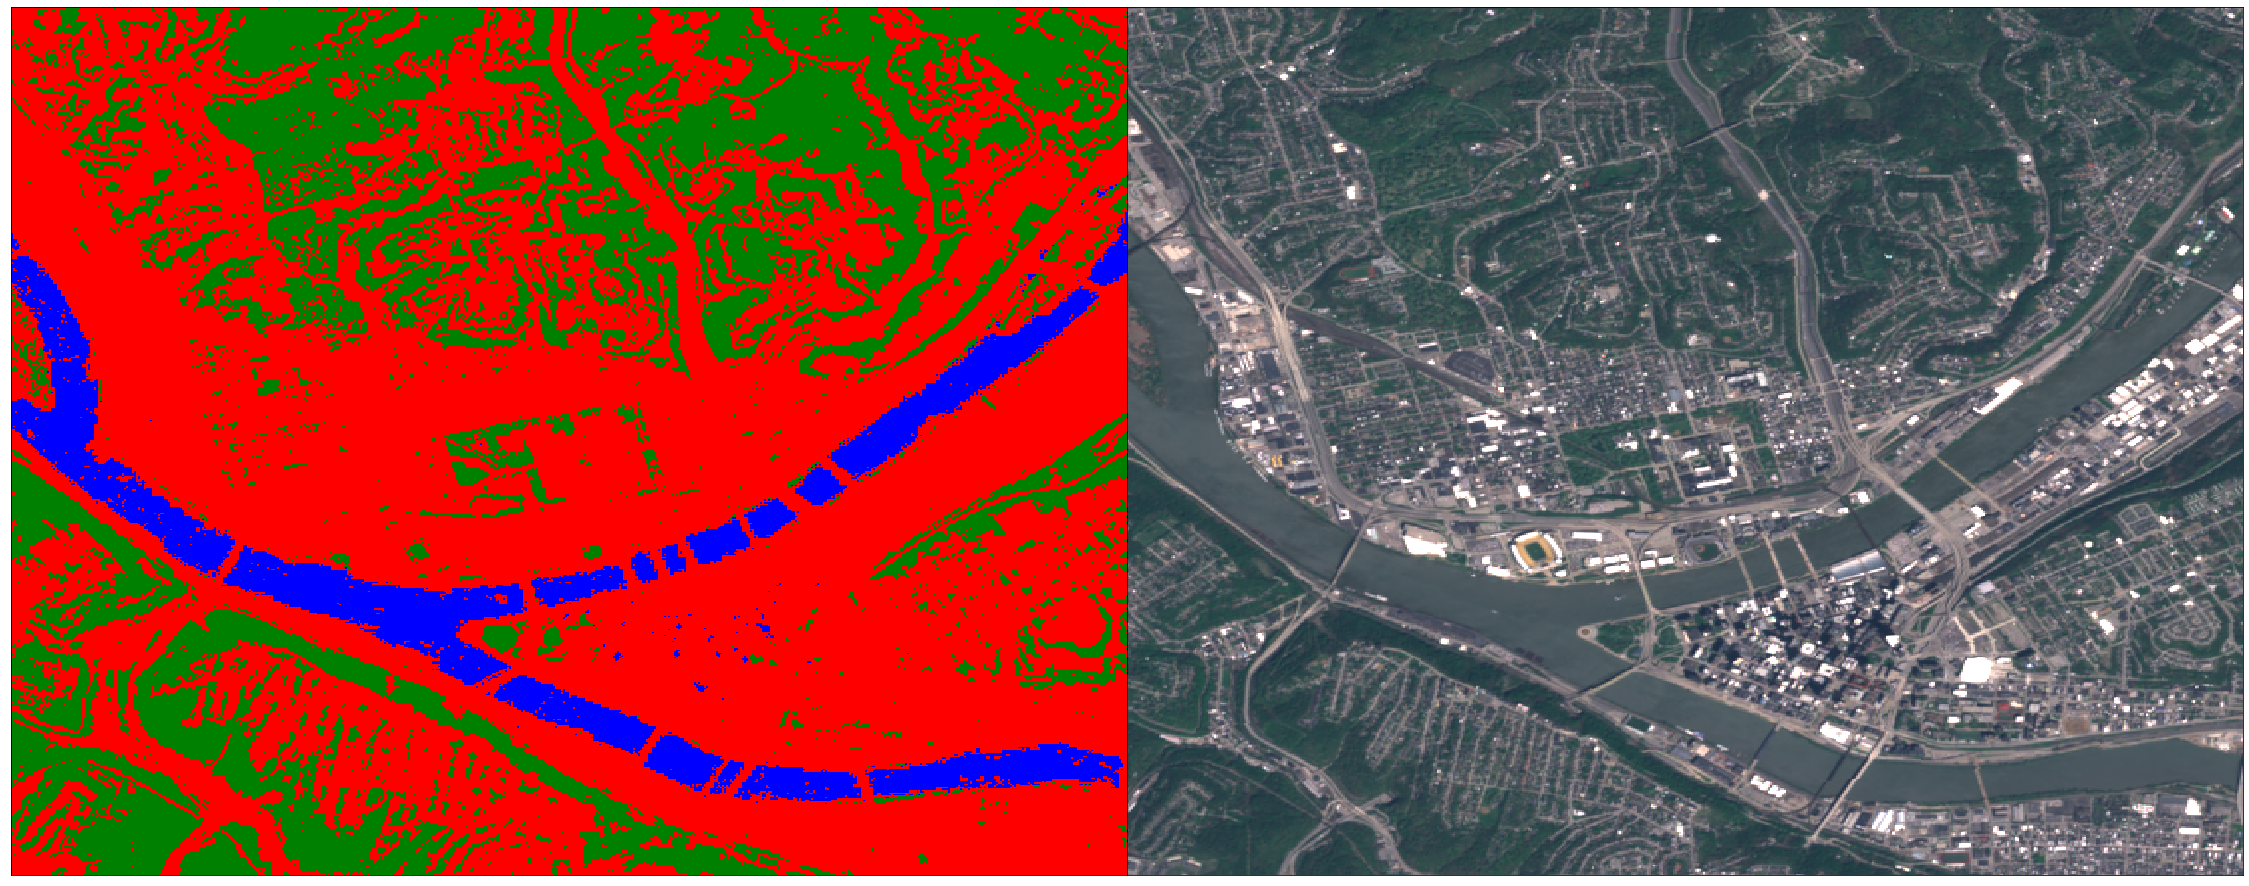

In [48]:
size=20
fig, ax = plt.subplots(figsize=(2*size*1, 1*size*scale), nrows=1, ncols=2)


eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, 0), lazy_loading=True)
im = ax[0].imshow(eopatch.mask_timeless['LBL'].squeeze(),cmap=lulc_cmap, norm=lulc_norm)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_aspect("auto")
pbar.update(1)

fig.subplots_adjust(wspace=0, hspace=0)




# Draw the RGB image


for i in range(0,1):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    ax = ax[1]
    plt.imshow(np.clip(eopatch.data['BANDS'][pic_n,:,:,:][..., [2,1,0]] * 3.5, 0, 1))
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    del eopatch

#fig.subplots_adjust(wspace=0, hspace=0)


In [50]:
raster=rasterio.open(path_out+'/predicted_tiff'+'/merged_prediction.tiff')
df=raster.bounds
sh_box=box(df.left, df.bottom, df.right, df.top)
shape_box=gpd.GeoDataFrame({'geometry': sh_box, 'col':[np.nan]})
shape_box.crs = {'init' :'epsg:4326'}
shape_box.to_file(path_out+'/shape_box')

In [51]:
if GUFF_data:

    with fiona.open(path_out+"/shape_box/shape_box.shp", "r") as shapefile:
        features = [feature["geometry"] for feature in shapefile]

    with rasterio.open(GUFF_data_dir) as src:
        out_image, out_transform = rasterio.mask.mask(src, features,
                                                            crop=True)
        out_meta = src.meta.copy()
        
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    with rasterio.open(path_out+"/masked_footprint.tif", "w", **out_meta) as dest:
        dest.write(out_image)

    mask = None
    with rasterio.Env():
        with rasterio.open(path_out+'/masked_footprint.tif') as src:
            image = src.read(1) # first band
            results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(
                shapes(image, mask=mask, transform=src.transform)))
    geoms_foot = list(results)      
    urban_foot=gpd.GeoDataFrame.from_features(geoms_foot)
    
    box_domain=gpd.read_file(path_out+'/shape_box/shape_box.shp')
    urban_foot=clip_shp(urban_foot,box_domain)
    urban_foot=urban_foot.rename(columns={'raster_val':'GUFF'})
    urban_foot=urban_foot[urban_foot.GUFF!=128]

    urban_foot_temp=urban_foot.buffer(0)
    urban_foot_temp=gpd.GeoDataFrame(urban_foot_temp)
    urban_foot_temp['GUFF']=urban_foot['GUFF']
    urban_foot_temp=urban_foot_temp.rename(columns={0:'geometry'})
    urban_foot_temp.crs={'init' :'epsg:4326'}
    urban_foot_temp.to_file(path_out+'/urban_foot_shape')

In [52]:
mask = None
with rasterio.Env():
    with rasterio.open(path_out+'/predicted_tiff/merged_prediction.tiff') as src:
        image = src.read(1) # first band
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(image, mask=mask, transform=src.transform)))
geoms_predict = list(results)      
predicted=gpd.GeoDataFrame.from_features(geoms_predict)

predicted=predicted.rename(columns={'raster_val':'predicted'})
predicted_temp=predicted.buffer(0)
predicted_temp=gpd.GeoDataFrame(predicted_temp)
predicted_temp['predicted']=predicted['predicted']
predicted_temp=predicted_temp.rename(columns={0:'geometry'})
predicted_temp.crs={'init' :'epsg:4326'}
predicted_temp.to_file(path_out+'/predicted_shape')



In [53]:
if GUFF_data:
    v1_dir=path_out+'/predicted_shape/predicted_shape.shp'
    v2_dir=path_out+'/urban_foot_shape/urban_foot_shape.shp'
    out_dir=path_out+'/predict_GUFF'
    grass_union(v1_dir,v2_dir,out_dir)
    
    predict_GUFF=gpd.read_file(path_out+'/predict_GUFF/predict_GUFF.shp')
    predict_GUFF=predict_GUFF[~np.isnan(predict_GUFF.a_predicte)]
    predict_GUFF['LC']=predict_GUFF.a_predicte
    a=predict_GUFF[predict_GUFF.b_GUFF==255]
    predict_GUFF.loc[a.index,'LC']=0
    b=predict_GUFF[(~np.isnan(predict_GUFF.b_GUFF))&(predict_GUFF.b_GUFF!=255) & (predict_GUFF.a_predicte==0)]
    predict_GUFF.loc[b.index,'LC']=3
    predict_GUFF=predict_GUFF.drop(['a_cat','b_GUFF','b_cat','a_predicte','cat'],axis=1)
    predict_GUFF_temp=predict_GUFF.buffer(0)
    predict_GUFF_temp=gpd.GeoDataFrame(predict_GUFF_temp)
    predict_GUFF_temp['LC']=predict_GUFF['LC']
    predict_GUFF_temp=predict_GUFF_temp.rename(columns={0:'geometry'})
    predict_GUFF_temp.crs={'init' :'epsg:4326'}
    predict_GUFF_temp.to_file(path_out+'/predict_GUFF_mod')

In [54]:
lon_deg_min, lat_deg_min=(lon_left_top,lat_right_bot)
lon_deg_max, lat_deg_max=(lon_right_bot,lat_left_top)
lat_rad_min=lat_deg_min*np.pi/180
lat_rad_max=lat_deg_max*np.pi/180

zoom=15
n = 2 **zoom

xtile_min = n * ((lon_deg_min + 180) / 360)
ytile_min = n * (1 - (np.log(np.tan(lat_rad_min) + (1/np.cos(lat_rad_min))) / np.pi)) / 2

xtile_max = n * ((lon_deg_max + 180) / 360)
ytile_max = n * (1 - (np.log(np.tan(lat_rad_max) + (1/np.cos(lat_rad_max))) / np.pi)) / 2

if ytile_max < ytile_min:
    temp=ytile_min
    ytile_min=ytile_max
    ytile_max=temp

ytile_min=int(np.floor(ytile_min))
ytile_max=int(np.ceil(ytile_max))

xtile_min=int(np.floor(xtile_min))
xtile_max=int(np.ceil(xtile_max))
#xtile_min=xtile_min-1

In [55]:
if Building_data =='OSM':
    to_wait=60
    path_OSM=path_out+'/OSM'
    if not os.path.isdir(path_OSM):
        os.makedirs(path_OSM)

    for i in tqdm(np.arange(xtile_min,xtile_max+1)):
        for j in np.arange(ytile_min,ytile_max+1):

            if not Path(path_OSM+'/buildings'+str(i)+'-'+str(j)+'.geojson').exists():
                url = 'https://a.data.osmbuildings.org/0.2/anonymous/tile/{}/{}/{}.json'.format(zoom,i,j)
                try:

                    r = requests.get(url,timeout=10)
                    while r.status_code==429:
                        print('Too many requests. Waiting for '+str(to_wait)+' seconds...')
                        time.sleep(to_wait)
                        print('Trying again')
                        r = requests.get(url,timeout=10)

                    with open(path_OSM+'/buildings'+str(i)+'-'+str(j)+'.geojson', 'wb') as f:  
                        f.write(r.content)
                except:
                    print('Passing this domain')

    print('All data are collected. DONE')


    counter=0
    for i in tqdm(range(xtile_min,xtile_max+1)):
        for j in range(ytile_min,ytile_max+1):

            try:
                b=gpd.read_file(path_OSM+'/buildings'+str(i)+'-'+str(j)+'.geojson')
                b=b.buffer(0)

                if counter==0:
                    a=b

                if counter!=0:
                    a=a.union(b)
                counter=1
            except:
                pass


    path_OSM_sh=path_OSM+'_sh'
    if not os.path.isdir(path_OSM_sh):
        os.makedirs(path_OSM_sh)

    a.to_file(path_OSM_sh)

In [56]:
box_domain=gpd.read_file(path_out+'/shape_box/shape_box.shp')

if Building_data =='OSM':
    buildings=gpd.read_file(path_out+'/OSM_sh/OSM_sh.shp')
elif Building_data=='MICROSOFT':
    buildings=gpd.read_file(building_dir)
print('Clipping the building data to the selected domain')        
buildings_clipped=clip_shp(buildings,box_domain)
buildings_clipped=buildings_clipped.buffer(0)
buildings_clipped=gpd.GeoDataFrame(buildings_clipped)
buildings_clipped['build']=1
buildings_clipped=buildings_clipped.rename(columns={0:'geometry'})
buildings_clipped.crs={'init' :'epsg:4326'}
print('Writing clipped data into '+path_out+'/'+Building_data+'_sh_clipped/')
buildings_clipped.to_file(path_out+'/'+Building_data+'_sh_clipped/')

Clipping the building data to the selected domain
Writing clipped data into Pittsburgh/MICROSOFT_sh_clipped/


In [59]:
if GUFF_data:

    v1_dir=path_out+'/predict_GUFF_mod/predict_GUFF_mod.shp'
    v2_dir=path_out+'/'+Building_data+'_sh_clipped/'+Building_data+'_sh_clipped.shp'
    out_dir=path_out+'/predict_GUFF_'+Building_data
    grass_union(v1_dir,v2_dir,out_dir)

    predict_GUFF_bld=gpd.read_file(path_out+'/predict_GUFF_'+Building_data+'/predict_GUFF_'+Building_data+'.shp')
    predict_GUFF_bld['LC']=predict_GUFF_bld.a_LC
    a=predict_GUFF_bld[predict_GUFF_bld.b_build==1]
    predict_GUFF_bld.loc[a.index,'LC']=4
    predict_GUFF_bld=predict_GUFF_bld.drop(['a_cat','b_cat','a_LC','b_build'],axis=1)
    predict_GUFF_bld_temp=predict_GUFF_bld.buffer(0)
    predict_GUFF_bld_temp=gpd.GeoDataFrame(predict_GUFF_bld_temp)
    predict_GUFF_bld_temp['LC']=predict_GUFF_bld['LC']
    predict_GUFF_bld_temp=predict_GUFF_bld_temp.rename(columns={0:'geometry'})
    predict_GUFF_bld_temp.crs={'init' :'epsg:4326'}
    predict_GUFF_bld_temp.to_file(path_out+'/predict_GUFF_'+Building_data+'_mod')
    
else:
    
    v1_dir=path_out+'/predicted_shape/predicted_shape.shp'
    v2_dir=path_out+'/'+Building_data+'_sh_clipped/'+Building_data+'_sh_clipped.shp'
    out_dir=path_out+'/predict_'+Building_data
    grass_union(v1_dir,v2_dir,out_dir)

    predict_bld=gpd.read_file(path_out+'/predict_'+Building_data+'/predict_'+Building_data+'.shp')
    predict_bld['LC']=predict_bld.a_predicte
    a=predict_bld[predict_bld.b_build==1]
    predict_bld.loc[a.index,'LC']=3
    predict_bld=predict_bld.drop(['a_cat','b_cat','a_predicte','b_build'],axis=1)
    predict_bld_temp=predict_bld.buffer(0)
    predict_bld_temp=gpd.GeoDataFrame(predict_bld_temp)
    predict_bld_temp['LC']=predict_bld['LC']
    predict_bld_temp=predict_bld_temp.rename(columns={0:'geometry'})
    predict_bld_temp.crs={'init' :'epsg:4326'}
    predict_bld_temp.to_file(path_out+'/predict_'+Building_data+'_mod')